In [1]:
import pandas as pd
import numpy as np
import json
import glob
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from geopy.distance import vincenty as distance
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, IFrame

sns.set_context('notebook', font_scale=1.6)
%matplotlib inline

# Goals

1. Chained Indexing == BAD so STOP
    * Use iloc, loc
2. Introduce concept of chained operations
2. Best methods in chained operations:
    * query
    * assign
    * groupby
    * stack, pivot
    * merge
    * pipe

Inspiration by Tom Augsburger (top 3 commiter for Pandas):  
https://tomaugspurger.github.io/modern-1.html

# Load the data

download data from here:  
https://www.divvybikes.com/data

In [2]:
def load_divvy_data():
    
    # load trip data from multiple csv files
    dfs = []
    parser = lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M")
    
    for fn in glob.iglob('divvy_data/Divvy_Trips*.csv'):
        dfs.append(pd.read_csv(fn,
                               parse_dates=['starttime', 'stoptime'],
                               date_parser=parser)
                   )
    trips = pd.concat(dfs)
    
    # load stations from csv
    stations = pd.read_csv('divvy_data/Divvy_Stations_2016_Q1Q2.csv')
    return trips, stations


trips, stations = load_divvy_data()

print trips.info()
display(trips.head())

print '\n\n', stations.info()
display(stations.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469740 entries, 0 to 396912
Data columns (total 12 columns):
trip_id              1469740 non-null int64
starttime            1469740 non-null datetime64[ns]
stoptime             1469740 non-null datetime64[ns]
bikeid               1469740 non-null int64
tripduration         1469740 non-null int64
from_station_id      1469740 non-null int64
from_station_name    1469740 non-null object
to_station_id        1469740 non-null int64
to_station_name      1469740 non-null object
usertype             1469740 non-null object
gender               1146765 non-null object
birthyear            1146915 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(5), object(4)
memory usage: 145.8+ MB
None


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 6 columns):
id             535 non-null int64
name           535 non-null object
latitude       535 non-null float64
longitude      535 non-null float64
dpcapacity     535 non-null int64
online_date    535 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 25.1+ KB
None


,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880456,-87.653929,19,6/26/2013


# Chained[Index][ing] == BAD so STOP

### Pandas slice / view:
Portion or Cut of the dataframe which shares the location in memory with original dataframe.
```python
df['column']
```

### Pandas copy:
Copy of the original dataframe into a new location in memory. Any manipulations of a copied dataframe have no impact on original dataframe.

```python
df[df.column > x]['column']
```

In [3]:
# prepare example data for demo
example = trips.head(5).copy()

example['length_of_trip'] = 'short_trip'
example

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,short_trip


### Poor form using index chaining

In [4]:
example[example.tripduration > 1000]['length_of_trip'] = 'long_trip'
example

/Users/scottcronin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,short_trip


### Best Practice using loc

In [5]:
example.loc[example.tripduration > 1000, 'length_of_trip'] = 'long_trip'
example

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,length_of_trip
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,733,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,short_trip
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,556,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,short_trip
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,253,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,short_trip
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,802,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,short_trip
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,1146,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,long_trip


Best practices:
* use .loc, .iloc, and if absolutely needed, then .ix
* do not ever chain index operations


http://pandas.pydata.org/pandas-docs/stable/indexing.html#different-choices-for-indexing

# What is Operation Chaining???

Applying multiple methods of the pandas class in a linear fashion.


Shortest five trips from each station:

In [6]:
(
    trips
    .groupby(['from_station_name', 'to_station_name'])
    .agg({'tripduration': 'min'})
    .reset_index()
    .sort_values(['from_station_name', 'tripduration'])
    .groupby('from_station_name')
    .head(5)
).head(10)

,from_station_name,to_station_name,tripduration
0,2112 W Peterson Ave,2112 W Peterson Ave,73
23,2112 W Peterson Ave,Maplewood Ave & Peterson Ave,191
32,2112 W Peterson Ave,Western Ave & Granville Ave,214
11,2112 W Peterson Ave,Clark St & Elmdale Ave,379
13,2112 W Peterson Ave,Clark St & Schreiber Ave,389
35,63rd St Beach,63rd St Beach,69
63,63rd St Beach,Museum of Science and Industry,343
45,63rd St Beach,Dorchester Ave & 63rd St,416
66,63rd St Beach,Shore Dr & 55th St,490
67,63rd St Beach,South Shore Dr & 67th St,508


What many people do which is much less readable:

In [7]:
shortest_trips = trips.groupby(['from_station_name', 'to_station_name']).tripduration.min().reset_index()
shortest_5 = shortest_trips.sort_values(['from_station_name', 'tripduration']).groupby('from_station_name').head(5)

shortest_5.head(10)

,from_station_name,to_station_name,tripduration
0,2112 W Peterson Ave,2112 W Peterson Ave,73
23,2112 W Peterson Ave,Maplewood Ave & Peterson Ave,191
32,2112 W Peterson Ave,Western Ave & Granville Ave,214
11,2112 W Peterson Ave,Clark St & Elmdale Ave,379
13,2112 W Peterson Ave,Clark St & Schreiber Ave,389
35,63rd St Beach,63rd St Beach,69
63,63rd St Beach,Museum of Science and Industry,343
45,63rd St Beach,Dorchester Ave & 63rd St,416
66,63rd St Beach,Shore Dr & 55th St,490
67,63rd St Beach,South Shore Dr & 67th St,508


# Useful Methods in Operation Chaining

## .query()

In [8]:
starting_stations = ['Millennium Park', 'Shedd Aquarium']

(
    trips
    .query("tripduration < 60*30")
    .query("usertype == 'Subscriber'")
    .query("'2016-06-01' < starttime < '2016-07-01'")
    .query("from_station_name in @starting_stations")
).head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
360,10426207,2016-06-30 22:35:00,2016-06-30 22:44:00,2826,570,90,Millennium Park,112,Green St & Randolph St,Subscriber,Male,1987.0
449,10426086,2016-06-30 22:22:00,2016-06-30 22:49:00,2881,1595,90,Millennium Park,171,May St & Cullerton St,Subscriber,Male,1986.0
603,10425875,2016-06-30 22:02:00,2016-06-30 22:18:00,3863,986,90,Millennium Park,255,Indiana Ave & Roosevelt Rd,Subscriber,Female,1977.0
844,10425589,2016-06-30 21:34:00,2016-06-30 21:55:00,867,1270,90,Millennium Park,341,Adler Planetarium,Subscriber,Male,1981.0
897,10425518,2016-06-30 21:28:00,2016-06-30 21:34:00,812,364,90,Millennium Park,191,Canal St & Monroe St (*),Subscriber,Male,1969.0


## .assign()

In [9]:
(
    trips
    .assign(age=lambda df: 2016 - df.birthyear)
    .assign(tripduration = lambda df: df.tripduration / 60.)
).head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
0,9379901,2016-04-30 23:59:00,2016-05-01 00:11:00,21,12.216667,123,California Ave & Milwaukee Ave,374,Western Ave & Walton St,Subscriber,Male,1982.0,34.0
1,9379900,2016-04-30 23:58:00,2016-05-01 00:07:00,3583,9.266667,349,Halsted St & Wrightwood Ave,165,Clark St & Grace St,Subscriber,Male,1991.0,25.0
2,9379899,2016-04-30 23:58:00,2016-05-01 00:02:00,4557,4.216667,59,Wabash Ave & Roosevelt Rd,273,Michigan Ave & 18th St,Subscriber,Male,1984.0,32.0
3,9379898,2016-04-30 23:54:00,2016-05-01 00:08:00,2443,13.366667,289,Wells St & Concord Ln,199,Wabash Ave & Grand Ave,Subscriber,Male,1978.0,38.0
4,9379897,2016-04-30 23:52:00,2016-05-01 00:11:00,50,19.100000,239,Western Ave & Leland Ave,227,Southport Ave & Waveland Ave,Customer,NaN,NaN,NaN


look at age of riders

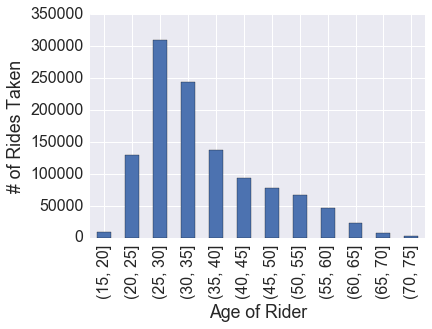

In [10]:
(
    trips
    .assign(age=lambda df: 2016 - df.birthyear)
    .assign(age_cut=lambda df: pd.cut(df.age, bins=np.arange(15, 80, 5)))
    .loc[:, 'age_cut']
    .value_counts()
    .sort_index()
    .plot(kind='bar')
)

plt.ylabel('# of Rides Taken')
plt.xlabel('Age of Rider')
plt.show()

## .pivot_table() and .stack()

Most popular stations

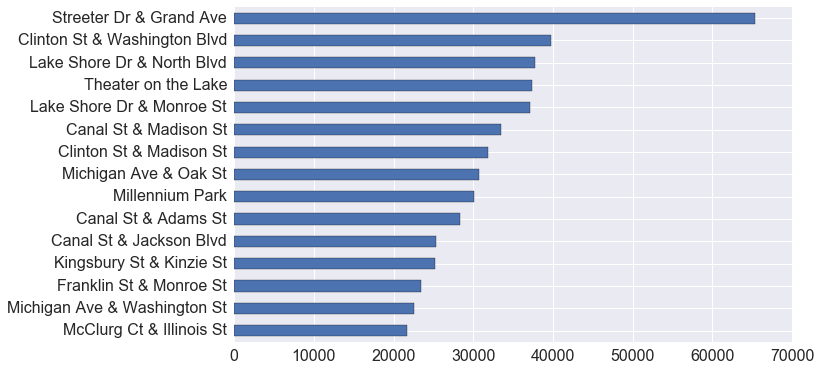

Index([u'Streeter Dr & Grand Ave', u'Clinton St & Washington Blvd',
       u'Lake Shore Dr & North Blvd', u'Theater on the Lake',
       u'Lake Shore Dr & Monroe St', u'Canal St & Madison St',
       u'Clinton St & Madison St', u'Michigan Ave & Oak St',
       u'Millennium Park', u'Canal St & Adams St', u'Canal St & Jackson Blvd',
       u'Kingsbury St & Kinzie St', u'Franklin St & Monroe St',
       u'Michigan Ave & Washington St', u'McClurg Ct & Illinois St',
       u'LaSalle St & Jackson Blvd', u'Shedd Aquarium',
       u'Clinton St & Lake St', u'Dearborn St & Monroe St',
       u'Franklin St & Jackson Blvd', u'Michigan Ave & Lake St',
       u'Columbus Dr & Randolph St', u'Wabash Ave & Grand Ave',
       u'Orleans St & Ohio St', u'Dearborn St & Erie St',
       u'Wabash Ave & Roosevelt Rd', u'Indiana Ave & Roosevelt Rd',
       u'St. Clair St & Erie St', u'Daley Center Plaza',
       u'Wells St & Concord Ln'],
      dtype='object')


In [11]:

station_popularity = (
    trips
    .loc[:, ['from_station_name', 'to_station_name']]
    .stack()
    .value_counts()
)

# display(station_popularity.head(10))

plt.figure(figsize=(10,6))
station_popularity[:15].sort_values().plot(kind='barh')
plt.show()

top_30_stations = station_popularity[:30].index
print top_30_stations

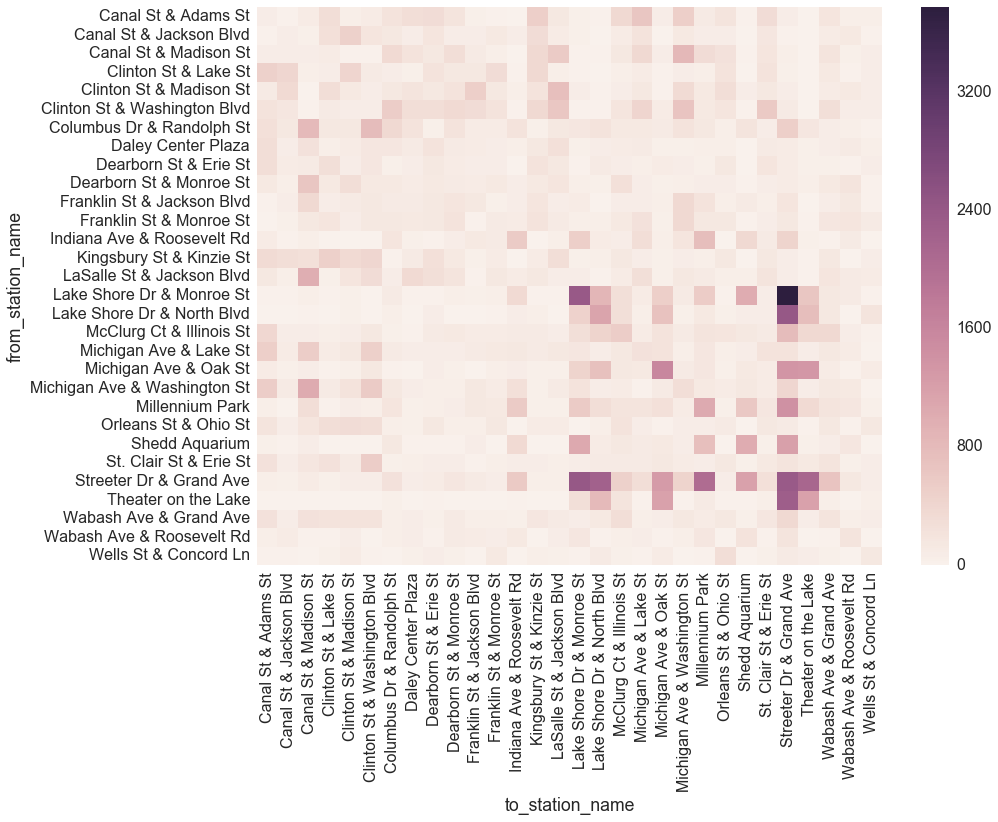

In [12]:
plt.figure(figsize=(14,10))

(
    trips
    .query('from_station_name in @top_30_stations')
    .query('to_station_name in @top_30_stations')
    .pivot_table(index='from_station_name',
                 columns='to_station_name',
                 values='tripduration',
                 aggfunc='count',
                 fill_value=0)
    .pipe((sns.heatmap, 'data'))
)

plt.show()

In [13]:
display(IFrame(src="https://www.google.com/maps/embed?pb=!1m28!1m12!1m3!1d5940.592056997682!2d-87.61877372071832!3d41.88649026688582!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!4m13!3e1!4m5!1s0x880e2b53ae8b98ed%3A0x60fe1c775623eabf!2sEast+Grand+Avenue+%26+North+Streeter+Drive%2C+Chicago%2C+IL+60611!3m2!1d41.8919642!2d-87.61160269999999!4m5!1s0x880e2b58c766aa85%3A0x6a3ce76eb41e58c6!2sSouth+Lake+Shore+Drive+%26+East+Monroe+Street%2C+Chicago%2C+IL!3m2!1d41.88091!2d-87.6174953!5e0!3m2!1sen!2sus!4v1471450449510", width="600", height="450", frameborder="0"))
display(IFrame(src="https://www.google.com/maps/embed?pb=!1m28!1m12!1m3!1d23753.796062511927!2d-87.63886650004417!3d41.909532220049854!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!4m13!3e1!4m5!1s0x880e2b53ae8b98ed%3A0x60fe1c775623eabf!2sEast+Grand+Avenue+%26+North+Streeter+Drive%2C+Chicago%2C+IL+60611!3m2!1d41.8919642!2d-87.61160269999999!4m5!1s0x880fd371b5b609f7%3A0x541c4a9e1b472c69!2sTheatre+On+the+Lake%2C+North+Lake+Shore+Drive%2C+Chicago%2C+IL!3m2!1d41.9271029!2d-87.6306989!5e0!3m2!1sen!2sus!4v1471450621256", width="600", height="450", frameborder="0"))
display(IFrame(src="https://www.google.com/maps/embed?pb=!1m28!1m12!1m3!1d11878.041226901607!2d-87.62742060263695!3d41.90338741752192!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!4m13!3e1!4m5!1s0x880e2b53ae8b98ed%3A0x60fe1c775623eabf!2sEast+Grand+Avenue+%26+North+Streeter+Drive%2C+Chicago%2C+IL+60611!3m2!1d41.8919642!2d-87.61160269999999!4m5!1s0x880fd32402d070cf%3A0x9dd183b927154048!2sNorth+Avenue+Beach%2C+1600+North+Lake+Shore+Drive%2C+Chicago%2C+IL+60613!3m2!1d41.9148113!2d-87.6251085!5e0!3m2!1sen!2sus!4v1471450804417", width="600", height="450", frameborder="0"))

## .merge() and .pipe()

In [14]:
def calculate_distance(df):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    cols = ['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y']
    
    dist = (
        df.loc[:, cols]
        .applymap(radians)
        .assign(dlat=lambda df: df.latitude_y - df.latitude_x)
        .assign(dlon=lambda df: df.longitude_y - df.longitude_x)
        .assign(a=lambda df:
                ((df.dlat / 2.).map(sin))**2 +
                df.latitude_x.map(cos) *
                df.latitude_y.map(cos) *
                ((df.dlon / 2.).map(sin))**2)
        .assign(dist=lambda df: df.a.map(sqrt).map(asin) * 2 * 3956)
        .loc[:, 'dist']
    )
    df['dist'] = dist
    
    return df

In [15]:
trip_dists = (
    trips
    .assign(tripduration=lambda df: df.tripduration / 60.)
    .query("tripduration <= 30.0")
    .loc[:, ['trip_id', 'starttime', 'tripduration',
             'from_station_id', 'to_station_id',
             'from_station_name', 'to_station_name']]
    .merge(
        stations
        .loc[:, ['id', 'latitude', 'longitude']],
        how='left',
        left_on=['from_station_id'],
        right_on=['id'])

    .merge(
        stations
        .loc[:, ['id', 'latitude', 'longitude']],
        how='left',
        left_on=['to_station_id'],
        right_on=['id'])
    
    .pipe(calculate_distance)
    .drop(['id_x', 'id_y', 'from_station_id',
           'to_station_id'], axis=1)
    .sort_values('dist', ascending=False)
)

display(trip_dists.head(10))

,trip_id,starttime,tripduration,from_station_name,to_station_name,latitude_x,longitude_x,latitude_y,longitude_y,dist
1143551,8847858,2016-03-02 22:39:00,23.233333,Canal St & Madison St,Broadway & Berwyn Ave,41.882091,-87.639833,41.978353,-87.659753,6.724734
1205512,8762801,2016-02-18 15:29:00,29.450000,Streeter Dr & Grand Ave,Lakefront Trail & Bryn Mawr Ave,41.892278,-87.612043,41.984037,-87.652310,6.664532
1100869,8905651,2016-03-10 13:06:00,28.450000,Lincoln Ave & Winona St,St. Clair St & Erie St,41.974911,-87.692503,41.894448,-87.622663,6.613062
514954,9418301,2016-05-04 14:53:00,24.200000,St. Clair St & Erie St,Lincoln Ave & Winona St,41.894448,-87.622663,41.974911,-87.692503,6.613062
1130370,8866779,2016-03-06 16:12:00,29.150000,Lake Shore Dr & Ohio St,Lakefront Trail & Bryn Mawr Ave,41.892570,-87.614492,41.984037,-87.652310,6.607304
123834,9207102,2016-04-16 15:57:00,27.366667,Lake Shore Dr & Monroe St,Shore Dr & 55th St,41.880958,-87.616743,41.795212,-87.580715,6.203655
1041417,8985080,2016-03-20 16:18:00,29.750000,Lake Shore Dr & Monroe St,Shore Dr & 55th St,41.880958,-87.616743,41.795212,-87.580715,6.203655
124423,9206291,2016-04-16 15:27:00,29.250000,Shore Dr & 55th St,Lake Shore Dr & Monroe St,41.795212,-87.580715,41.880958,-87.616743,6.203655
132672,9194603,2016-04-15 18:14:00,29.950000,Lakefront Trail & Bryn Mawr Ave,Mies van der Rohe Way & Chestnut St,41.984037,-87.652310,41.898587,-87.621915,6.102932
345743,9652843,2016-05-22 09:21:00,28.400000,Broadway & Berwyn Ave,St. Clair St & Erie St,41.978353,-87.659753,41.894448,-87.622663,6.098417


In [16]:
def show_google_maps(df, index):
    lat_x, long_x = df.loc[index, 'latitude_x'], df.loc[index, 'longitude_x']
    lat_y, long_y = df.loc[index, 'latitude_y'], df.loc[index, 'longitude_y']

    url = ("https://www.google.com/maps/embed?pb=!1m26!1m12!1m3"
           "!1d94984.41444534011!2d-87.71636148530142!"
           "3d41.93020071811045!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!"
           "4f13.1!4m11!3e1!4m4!2s{lat_x}%2C+{long_x}!3m2!1d"
           "41.882090999999996!2d{long_x}!4m4!2s{lat_y}%2C+"
           "{long_y}!3m2!1d{lat_y}!2d{long_y}"
           "!5e0!3m2!1sen!2sus!4v1470808071878"
           ).format(lat_x=lat_x, long_x=long_x,
                    lat_y=lat_y, long_y=long_y)
    
    display(IFrame(url, width=600, height=450))


# show 3 longest trips on Divvys in < 30 minutes
for i in trip_dists.index[:3]:
    date = trip_dists.loc[i, 'starttime']
    dist = trip_dists.loc[i, 'dist']
    duration = trip_dists.loc[i, 'tripduration']
    
    print '\n\nTrip on: {}\nSpherical Distance: {}\nTrip Duration: {}'.format(date, dist, duration)
    show_google_maps(trip_dists, i)



Trip on: 2016-03-02 22:39:00
Spherical Distance: 6.72473377908
Trip Duration: 23.2333333333




Trip on: 2016-02-18 15:29:00
Spherical Distance: 6.66453192322
Trip Duration: 29.45




Trip on: 2016-03-10 13:06:00
Spherical Distance: 6.61306231818
Trip Duration: 28.45
